# Compare time averages of FOCI-OpenIFS runs

In [32]:
# get the modules we need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [33]:
from dask.distributed import Client, LocalCluster, wait

In [34]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33181 instead
  expected, actual


In [35]:
client

Client Scheduler: tcp://127.0.0.1:33003 Dashboard: http://127.0.0.1:33181/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [36]:
# Get the NEMO mesh (points to my personal dir, you should change to yours!)
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'
    oifs_area = '/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK010/outdata/oifs/areacella.nc'

# Read NEMO grid

In [37]:
# NEMO mesh file has "z" as vertical coordinate
# but the grid_T files have "deptht" so we need to rename
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_dxt, da_orca05_dyt = ds_mesh['e1t'].sel(t=0), ds_mesh['e2t'].sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

In [38]:
## Read OpenIFS grid

In [39]:
ds_oifs = xr.open_dataset(oifs_area)
da_oifs_area = ds_oifs['areacella']

In [40]:
# global mean for NEMO T grid
def global_tmean(data):
    weights = da_orca05_area * da_orca05_mask
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('x','y'))
    
    return data_mean

def global_zonmean(data):
    weights = da_orca05_area * da_orca05_mask
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('x'))
    
    return data_mean

def global_tsum(data):
    area = da_orca05_area * da_orca05_mask
    data_a = (data * area).sum(('x','y'))
    return data_a

# global mean for OpeniFS
def global_mean(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    
    data_wgt = data.weighted(weights)
    data_mean = data_wgt.mean(('lon','lat'))
    
    return data_mean

def global_sum(data):
    area = da_oifs_area
    data_mean = (data * area).sum(('lon','lat'))
    return data_mean

## Read data

In [41]:
# FOCI_GJK001 is the first long piControl for 1000 years
# FOCI_GJK006 continues from year 2850 of FOCI_GJK001, but couples E,P separately instead of E-P as one field
# This does not seem to alter the mean climate in any way

# Will compare exps [1:] to exp [0]

exp_list = ['foci-rcl-01', 'foci-22-01', 'foci-22-02']
time_list = [slice('4000-01-01','4100-01-01'),
             slice('4000-01-01','4100-01-01'),
             slice('4000-01-01','4100-01-01')]
version_list = [1, 1, 1]

nfrhis_list = [6,12,12]
utstep_list = [3600, 1800, 1800]

In [42]:
# OpenIFS surface
ds_sfc_all = []
for exp,time,ver in zip(exp_list,time_list,version_list):
    if ver == 1:
        sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    elif ver == 0:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    
    # open multi-file data set. We need to use cftime since the normal python calendar stops working after 2300. 
    # also, we rename time variable from time_counter to time to make life easier
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//foci-rcl-01/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-22-01/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-22-02/outdata/oifs/*1m*regular_sfc.nc


In [43]:
# OpenIFS pressure levels
# This is actually a lot of data, but XArray is only reading meta-data at this point
ds_pl_all = []
for exp,time,ver in zip(exp_list,time_list,version_list):
    if ver == 1:
        pl = '%s/%s/outdata/oifs/*1m*regular_pl.nc' % (esmdir,exp)
    elif ver == 0:
        pl = '%s/%s/outdata/oifs/1y/*1y*regular_pl.nc' % (esmdir,exp)
    print(pl)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_pl_all.append(ds_pl)

/gxfs_work1/geomar/smomw352/esm-experiments//foci-rcl-01/outdata/oifs/*1m*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-22-01/outdata/oifs/*1m*regular_pl.nc
/gxfs_work1/geomar/smomw352/esm-experiments//foci-22-02/outdata/oifs/*1m*regular_pl.nc


In [13]:
# NEMO grid T (annual means)
ds_t_all = []
for ver,exp,time in zip(version_list,exp_list,time_list):
    if ver == 1:
        t = '%s/%s/outdata/nemo/ym/*1y*grid_T.nc' % (esmdir,exp)
    else:   
        t = '%s/%s/outdata/nemo/1y/*1y*grid_T.nc' % (esmdir,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_t_all.append(ds_t)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK016/outdata/nemo/ym/*1y*grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK016/outdata/nemo/ym/*1y*grid_T.nc


# Surface variables (OpenIFS)

In [44]:
sfc_means = []
for i, ds_sfc in enumerate( ds_sfc_all ):
    sfc_means.append( ds_sfc.mean('time').compute() )
    
sfc_diffs = []
for i, ds_mean in enumerate( sfc_means[1:] ):
    sfc_diffs.append( ds_mean - sfc_means[0] )
    

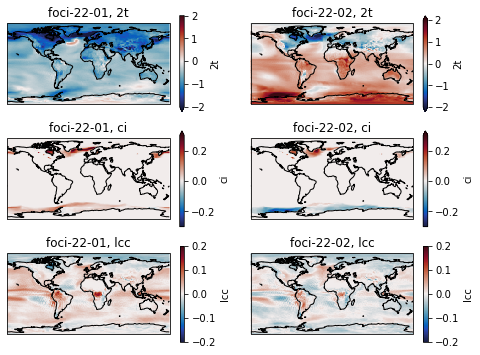

In [46]:
# Fluxes need to be scaled 
# They are stored in e.g. W/m2 * s
# So we divide by the frequency of XIOS call (usually 3hr for T95)
# To check this: 
# 1) look at the config/xios/context_ifs.xml and look for NFRHIS (might be 6 or 3)
# 2) look at the config/oifs/fort.4 and look for UTSTEP (might be 1800)
# 3) your XIOS call freq is UTSTEP * NFRHIS (e.g. 10800s = 3hr)

variables = ['2t','ci','lcc']
vmax = [2, 0.3, 0.2, 4, 4]

hfluxes = ['tisr','tsrc','ttrc','tsr','ttr']

figsize=(4*(len(exp_list)-1), 2*len(variables))

fig1, ax1 = plt.subplots(len(variables),len(exp_list)-1,
                         figsize=figsize,
                         subplot_kw={'projection':ccrs.PlateCarree()})

for i, ds_sfc in enumerate( sfc_diffs ):
    
    j = i+1
    exp = exp_list[j]
    
    # This should be 1/(NFRHIS * UTSTEP)
    flux_scale = 1./(nfrhis_list[j] * utstep_list[j])
    
    # Scale precip from m/s to mm/d
    pr_scale = 1000. * 86400. * flux_scale
    
    for jv, var in enumerate( variables ):
        
        vm = vmax[jv]
        
        # Read data
        _data = ds_sfc[var]
        
        if var in hfluxes:
            _data = ds_sfc[var] * flux_scale
        
        if len(exp_list) < 3:
            _ax = ax1[jv]
        else:
            _ax = ax1[jv,i]
            
        _data.plot.pcolormesh(ax=_ax, 
                              vmin=-vm, vmax=vm, 
                              cmap=cmocean.cm.balance,
                              transform=ccrs.PlateCarree())
        
        _ax.coastlines()
        _ax.set_title('%s, %s' % (exp,var))

## Mixed-layer depth variability

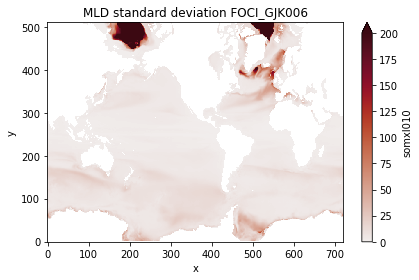

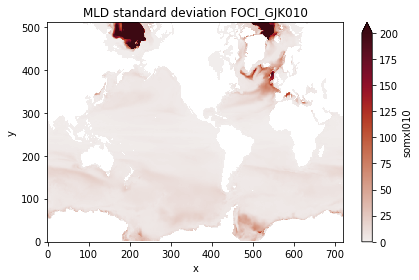

In [18]:
for i in range(0,len(exp_list)):
    
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Annual-mean MLD
    mld = ds_t['somxl010']
    
    # Standard dev
    mld_std = mld.where(mld != 0).std('time')
    
    mld_std.plot(ax=ax1, cmap=cmocean.cm.amp,
                 vmin=0, vmax=200, 
                 rasterized=True)
    
    ax1.set_title('MLD standard deviation %s' % (exp,))
    
    fig1.tight_layout()

## Deep convection

Compute deep convective volume (total volume of water where MLD>800m, i.e. deep convection). 
See definition in: Brodeau & Koenigk (2016), http://link.springer.com/10.1007/s00382-015-2736-5

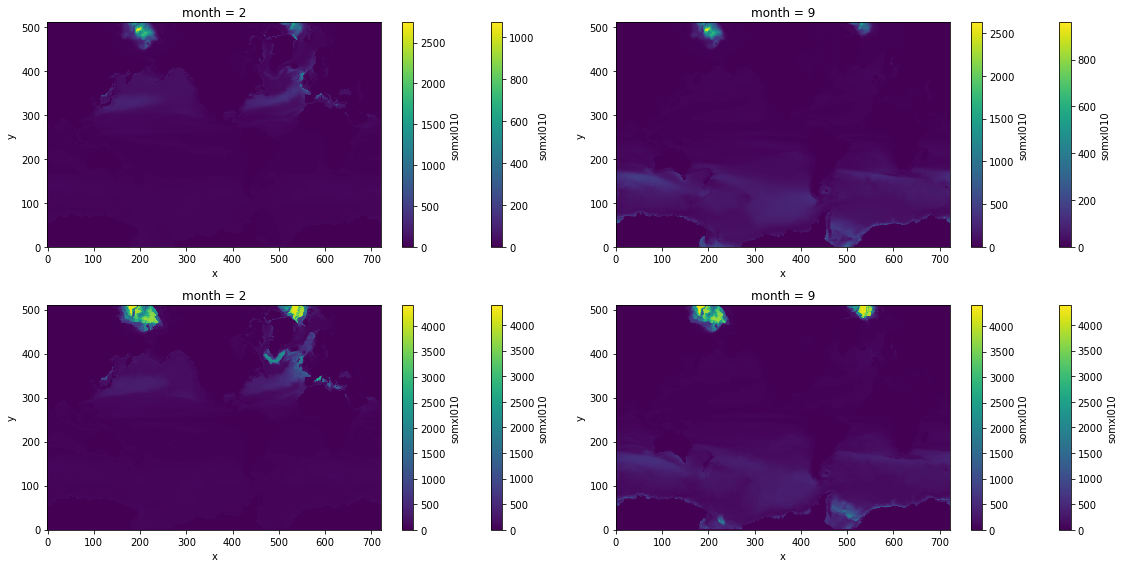

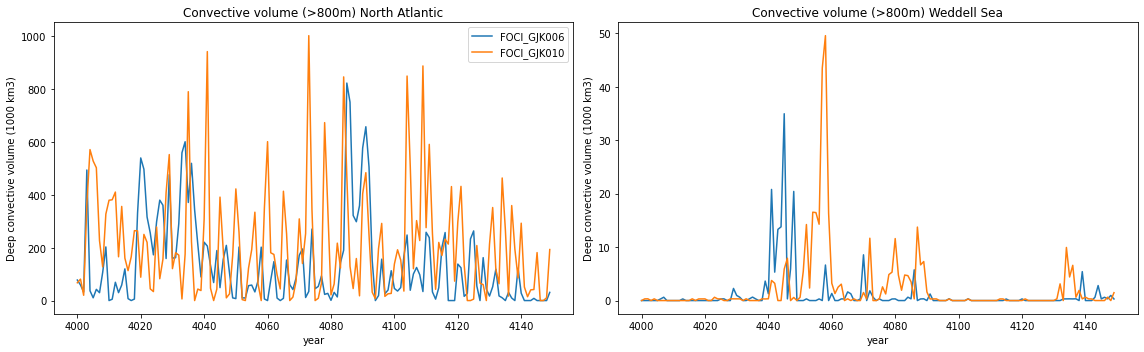

In [19]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(16,5))

for i in range(0,len(exp_list)):
    ds_t = ds_t_1m[i]
    exp = exp_list[i]
    mld = ds_t['somxl010']
    
    mld_s = mld.groupby('time.month').mean('time')
    
    # Select Feb and Sep
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[0,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[0,1])
    
    mld_s = mld.groupby('time.month').max('time')
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[1,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[1,1])
    
    # Convective volume (annual mean)
    mld_mask = mld.where(mld > 800).groupby('time.year').mean('time')
    # North Atlantic
    mld_natl = mld_mask.sel(x=slice(450,550),y=slice(350,450)) * da_orca05_area.sel(x=slice(450,550),y=slice(350,450))
    mld_natl_vol = mld_natl.sum(('x','y')) * 1e-12
    mld_natl_vol.plot(ax=axs2[0],label=exp)
    # Weddell Sea
    mld_wed = mld_mask.sel(x=slice(480,600),y=slice(50,150)) * da_orca05_area.sel(x=slice(480,600),y=slice(50,150))
    mld_wed_vol = mld_wed.sum(('x','y')) * 1e-12
    mld_wed_vol.plot(ax=axs2[1],label=exp)
    
axs2[0].set_title('Convective volume (>800m) North Atlantic')
axs2[1].set_title('Convective volume (>800m) Weddell Sea')
axs2[0].legend()
for ax in axs2:
    ax.set_ylabel('Deep convective volume (1000 km3)')

fig1.tight_layout()
fig2.tight_layout()
#fig1.savefig('mld_mean_max.png',format='png',dpi=150)
fig2.savefig('plots/deep_conv_vol.pdf',format='pdf')

## Sea ice

<xarray.DataArray 'ci' (month: 12, lat: 96, lon: 192)>
dask.array<stack, shape=(12, 96, 192), dtype=float32, chunksize=(1, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.DataArray 'ci' (month: 12, lat: 96, lon: 192)>
dask.array<stack, shape=(12, 96, 192), dtype=float32, chunksize=(1, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


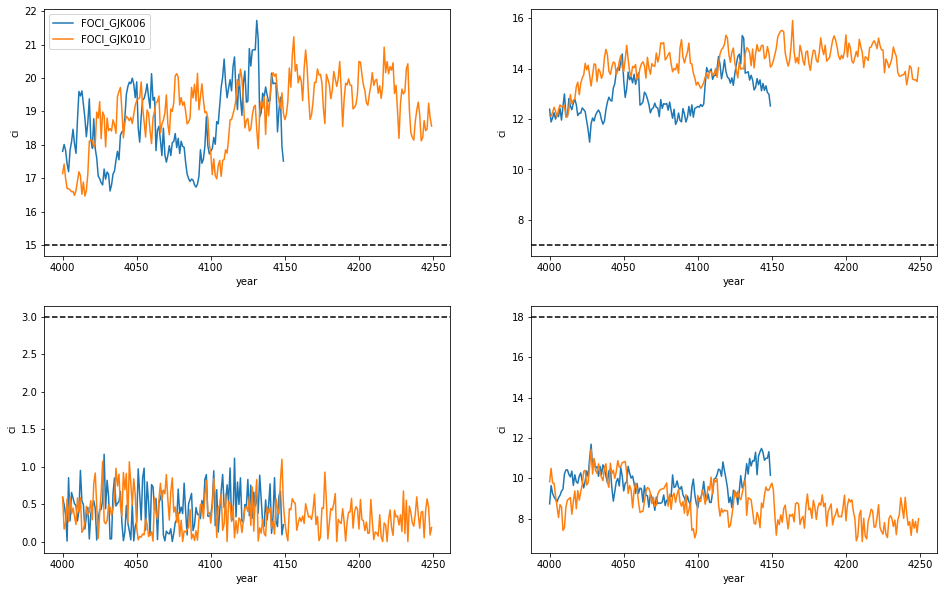

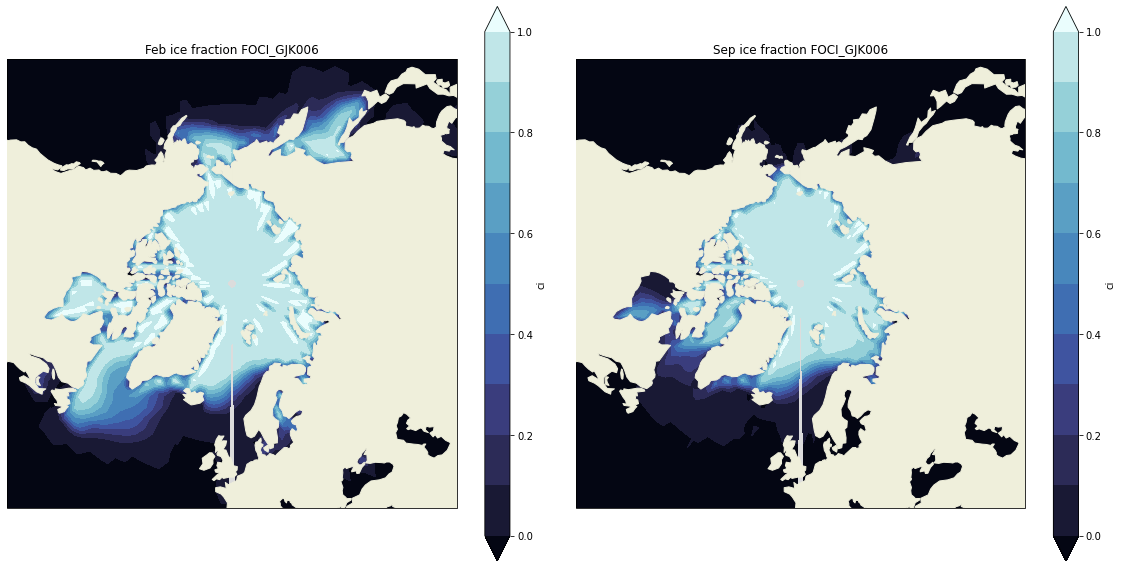

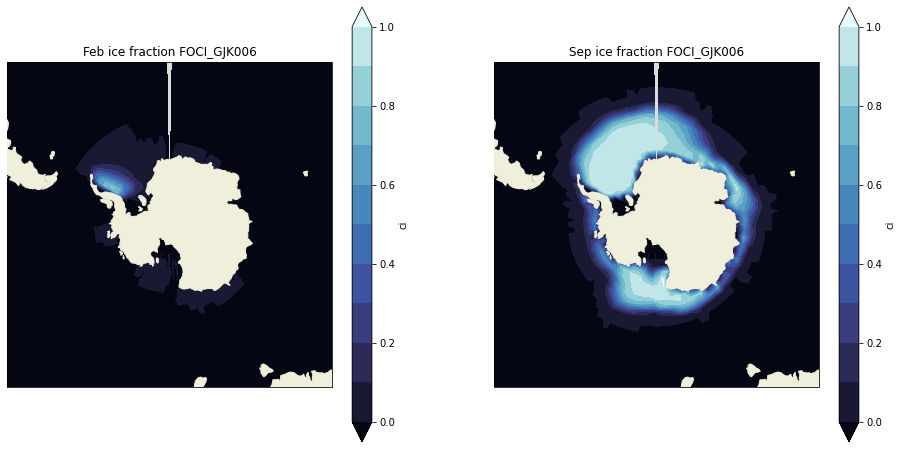

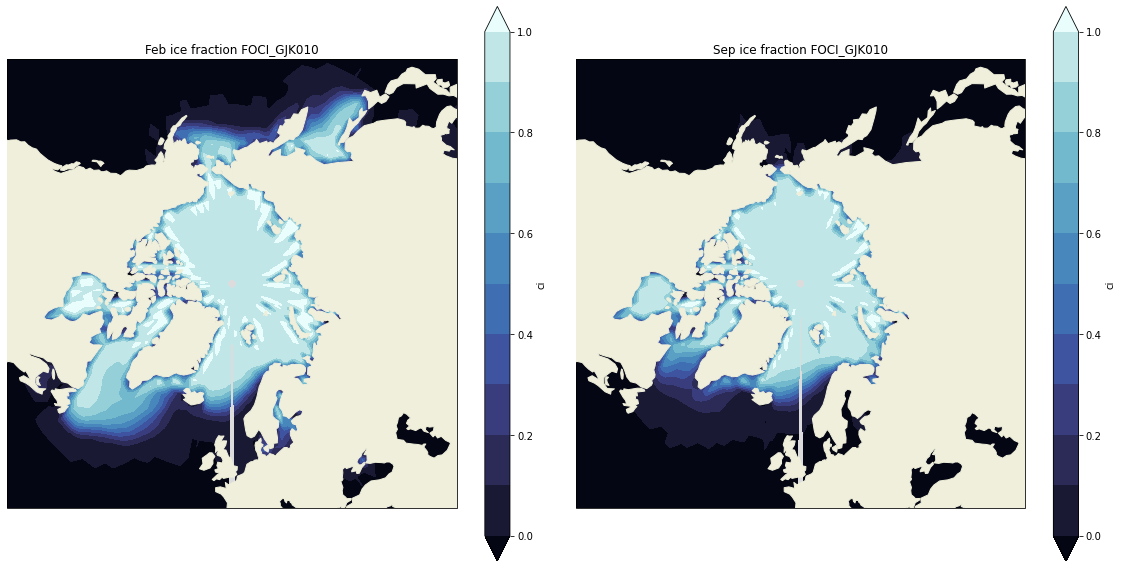

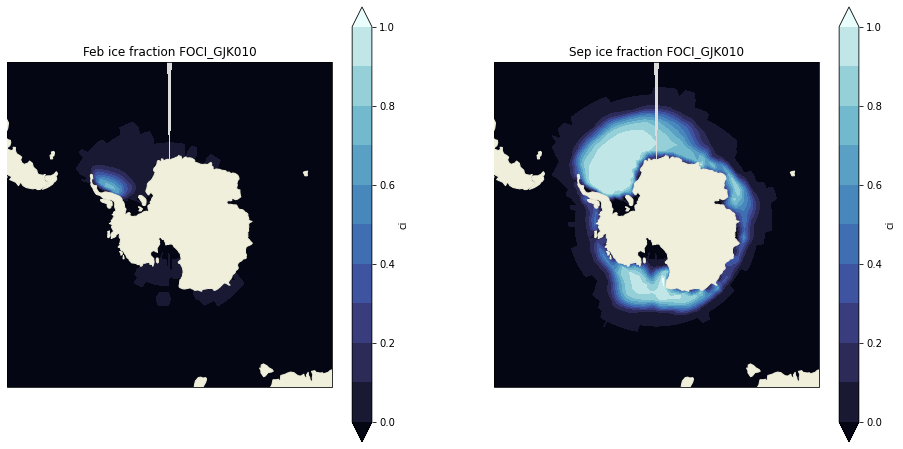

In [29]:
def ice_areas(ci, hemisphere=True):
    
    w = np.cos(np.deg2rad(ci.lat))
    w.name = "weights"
    
    # Earth is 510.1 million km2
    # NH and SH are half
    if hemisphere:
        scale = 510.1/2.0
    else:
        scale = 510.1
        
    # Select Feb and Sep sea ice, add weights, and area-average
    # Unit will be million km2
    ci_feb = ci.sel(time=ci.time.dt.month.isin([2])).groupby('time.year').mean('time').weighted(w).mean(('lon','lat')) * scale
    ci_sep = ci.sel(time=ci.time.dt.month.isin([9])).groupby('time.year').mean('time').weighted(w).mean(('lon','lat')) * scale
    ci_mon = ci.groupby('time.month').mean('time').weighted(w).mean(('lon','lat')) * scale
    
    return ci_feb, ci_sep, ci_mon

fig3, axs3 = plt.subplots(2,2,figsize=(16,10))
ax3 = axs3.flat

for i, (exp, ds_i) in enumerate( zip(exp_list, ds_sfc_1m_all) ):
    
    # Sea ice fraction
    ci = ds_i['ci']
    
    prj1 = ccrs.NorthPolarStereo()
    fig1, axs1 = plt.subplots(1,2,figsize=(16,8),subplot_kw={'projection':prj1})
    prj2 = ccrs.SouthPolarStereo()
    fig2, axs2 = plt.subplots(1,2,figsize=(16,8),subplot_kw={'projection':prj2})
    
    ci_mean = ci.groupby('time.month').mean('time')
    print(ci_mean)
    # Plot Feb and Sep
    #ci_mean.sel(month=2).plot.pcolormesh(ax=axs1[0],vmin=0,vmax=1,
    #                                     cmap=cmocean.cm.ice,
    #                                     transform=ccrs.PlateCarree())
    #ci_mean.sel(month=9).plot.pcolormesh(ax=axs1[1],vmin=0,vmax=1,
    #                                     cmap=cmocean.cm.ice,
    #                                     transform=ccrs.PlateCarree())
    
    for ax in [axs1[0], axs2[0]]:
        ci_mean.sel(month=2).plot.contourf(ax=ax,levels=np.linspace(0,1,11),
                                           cmap=cmocean.cm.ice,
                                           transform=ccrs.PlateCarree())
        ax.set_title('Feb ice fraction %s' % (exp,)) 
        
    for ax in [axs1[1], axs2[1]]:
        ci_mean.sel(month=9).plot.contourf(ax=ax,levels=np.linspace(0,1,11),
                                           cmap=cmocean.cm.ice,
                                           transform=ccrs.PlateCarree())
        ax.set_title('Sep ice fraction %s' % (exp,))
    
    for ax in axs1.flat:
        ax.set_facecolor('Gainsboro')
        ax.add_feature(cartopy.feature.LAND, zorder=100)
        ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
    
    for ax in axs2.flat:
        ax.set_facecolor('Gainsboro')
        ax.add_feature(cartopy.feature.LAND, zorder=100)
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
    
    fig1.tight_layout()
    #fig1.savefig('ice_mean_%s.png' % (exp,),format='png',dpi=150)
    
    ci_nh_feb, ci_nh_sep, ci_nh_mon = ice_areas(ci.sel(lat=slice(0,90)))
    ci_nh_feb.plot(ax=ax3[0], label='%s' % (exp,))
    ci_nh_sep.plot(ax=ax3[1], label='%s' % (exp,))
    
    ci_sh_feb, ci_sh_sep, ci_sh_mon = ice_areas(ci.sel(lat=slice(-90,0)))
    ci_sh_feb.plot(ax=ax3[2], label='%s' % (exp,))
    ci_sh_sep.plot(ax=ax3[3], label='%s' % (exp,))

ax3[0].legend()
ax3[1].axhline(y=7,linestyle='--',c='k')
ax3[0].axhline(y=15,linestyle='--',c='k')
ax3[2].axhline(y=3,linestyle='--',c='k')
ax3[3].axhline(y=18,linestyle='--',c='k')


#for ax in axs2:
#    ax.set_ylabel('Sea-ice extent (million km2)')
#    ax.legend()
#    
#fig2.tight_layout()
#fig2.savefig('ice_extent.pdf',format='pdf')

In [17]:
zz = z.compute()

In [ ]:
prj1 = ccrs.NorthPolarStereo()
prj2 = ccrs.SouthPolarStereo()
fig1 = plt.figure(figsize=(16,16))
axs1 = []
axs1.append( fig1.add_subplot(2,2,1,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,2,projection=prj1) )
axs1.append( fig1.add_subplot(2,2,3,projection=prj2) )
axs1.append( fig1.add_subplot(2,2,4,projection=prj2) )
print(zz.where(zz!=np.nan))
zz.sel(month=2).plot.pcolormesh(ax=axs1[0],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[1],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=2).plot.pcolormesh(ax=axs1[2],vmin=0,vmax=1,cmap=cmocean.cm.ice)
#zz.sel(month=9).plot.pcolormesh(ax=axs1[3],vmin=0,vmax=1,cmap=cmocean.cm.ice)
axs1[0].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[1].set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
axs1[2].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs1[3].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
for ax in axs1:
    ax.coastlines()
fig1.tight_layout()

<xarray.DataArray 'iicethic' (month: 12, y: 511, x: 722)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, .

# Radiative budget

<xarray.DataArray (time: 1000, lat: 96, lon: 192)>
dask.array<mul, shape=(1000, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-07-01 06:00:00 ... 2849-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
<xarray.DataArray (time: 70, lat: 96, lon: 192)>
dask.array<mul, shape=(70, 96, 192), dtype=float32, chunksize=(10, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2850-07-01 06:00:00 ... 2919-07-01 06:00:00
  * lon      (lon) float32 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float32 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06


No handles with labels found to put in legend.


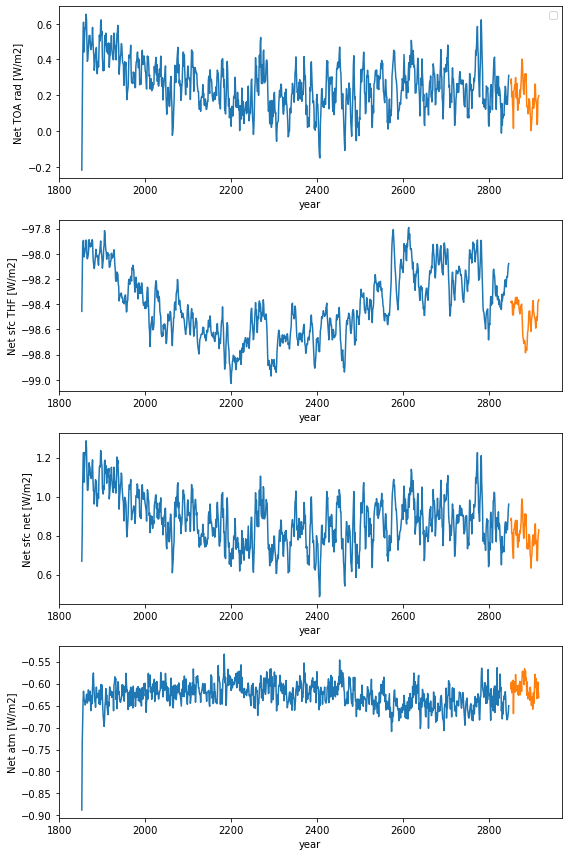

In [13]:
fscale = 1./(6 * 60 * 60.)

fig, ax = plt.subplots(4,1,figsize=(8,12))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i]
    
    # This run had the wrong scaling
    if exp == 'foci-test-07':
        fscale = fscale * 2
    
    # Net TOA
    toa = (ds_sfc['tsr'] + ds_sfc['ttr']) * fscale
    print(toa)
    # Net turb sfc 
    thf = (ds_sfc['sshf'] + ds_sfc['slhf']) * fscale
    # Net sfc rad
    sfc = (ds_sfc['ssr'] + ds_sfc['str']) * fscale
    # Net atm (pos when warming)
    net = toa - thf - sfc 
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(toa.lat))
    weights.name = "weights"
    
    toa_wgt = toa.weighted(weights)
    toa_mean = toa_wgt.mean(('lon','lat'))
    
    thf_wgt = thf.weighted(weights)
    thf_mean = thf_wgt.mean(('lon','lat'))
    
    sfc_wgt = sfc.weighted(weights)
    sfc_mean = sfc_wgt.mean(('lon','lat'))
    
    net_wgt = net.weighted(weights)
    net_mean = net_wgt.mean(('lon','lat'))
    
    # Annual mean
    toa = toa_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    toa.plot(ax=ax[0],alpha=1)
    
    thf = thf_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    thf.plot(ax=ax[1],alpha=1)
    
    sfc = sfc_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    (sfc+thf).plot(ax=ax[2],alpha=1)
    
    net = net_mean.groupby('time.year').mean('time').rolling(year=5,center=True).mean()
    net.plot(ax=ax[3],alpha=1)
    
ax[0].legend()
ax[0].set_ylabel('Net TOA rad [W/m2]')
ax[1].set_ylabel('Net sfc THF [W/m2]')
ax[2].set_ylabel('Net sfc net [W/m2]')
ax[3].set_ylabel('Net atm [W/m2]')
fig.tight_layout()
fig.savefig('plots/radiation_equilibration.pdf',format='pdf')

## Freshwater flux

In [69]:
tot_all = []
rnf_all = []
cal_all = []
ssh_all = []
arnf_all = []

for i in range(0,len(exp_list)):
    
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i] 
    
    tot = global_tsum(ds_t['sowaflup']).compute()
    rnf = global_tsum(ds_t['runoffs']).compute()
    cal = global_tsum(ds_t['calving']).compute()
    ssh = global_tmean(ds_t['sossheig']).compute()
    
    arf = global_sum((ds_sfc['sro'] + ds_sfc['ssro']) / (6.0*60*60))
    
    tot_all.append(tot)
    rnf_all.append(rnf)
    cal_all.append(cal)
    ssh_all.append(ssh)
    arnf_all.append(arf)

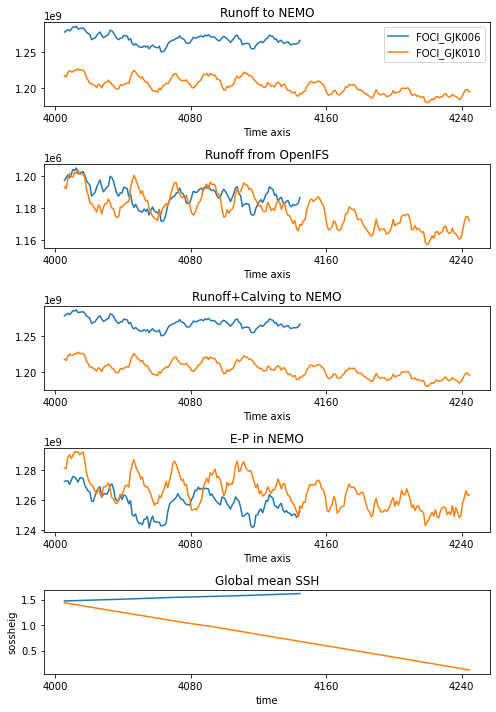

In [70]:
fig1, axs1 = plt.subplots(5,1,figsize=(7,10))
for ji,(rnf,arnf,cal,tot,ssh) in enumerate( zip(rnf_all,arnf_all,cal_all,tot_all,ssh_all) ):
    
    rnf.rolling(time=11,center=True).mean().plot(ax=axs1[0],label=exp_list[ji])
    arnf.rolling(time=11,center=True).mean().plot(ax=axs1[1],label=exp_list[ji])
    (cal+rnf).rolling(time=11,center=True).mean().plot(ax=axs1[2],label=exp_list[ji])
    (tot+rnf+cal).rolling(time=11,center=True).mean().plot(ax=axs1[3],label=exp_list[ji])
    ssh.rolling(time=11,center=True).mean().plot(ax=axs1[4],label=exp_list[ji])
    
axs1[0].legend()

axs1[0].set_title('Runoff to NEMO')
axs1[1].set_title('Runoff from OpenIFS')
axs1[2].set_title('Runoff+Calving to NEMO')
axs1[3].set_title('E-P in NEMO')
axs1[4].set_title('Global mean SSH')

fig1.tight_layout()
fig1.savefig('fw_fluxes.pdf',format='pdf')

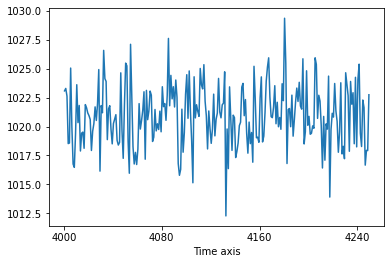

In [74]:
((rnf+cal)/arnf).plot()

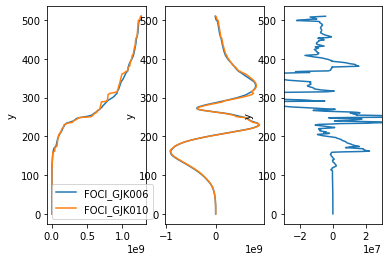

In [57]:
fig1, ax1 = plt.subplots(1,3)

for i in range(0,len(exp_list)):
    
    ds_t = ds_t_all[i]
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i] 
    
    #tot = global_zonmean(ds_t['sowaflup'].mean('time')).compute()
    #rnf = global_zonmean(ds_t['runoffs'].mean('time')).compute()
    #cal = global_zonmean(ds_t['calving']).compute()
    #ssh = global_zonmean(ds_t['sossheig']).compute()
    
    tot = (ds_t['sowaflup'].mean('time') * da_orca05_area).sum('x').compute()
    rnf = ((ds_t['runoffs'].fillna(0)+ds_t['calving'].fillna(0)).mean('time') * da_orca05_area).sum('x').compute()
    
    tot_c = tot.cumsum('y')
    rnf_c = rnf.cumsum('y')
    
    rnf_c.plot(ax=ax1[0],label=exp,y='y')
    tot_c.plot(ax=ax1[1],label=exp,y='y')
    
    if i == 0:
        _ref = rnf_c
    else:
        _diff = rnf_c - _ref
        _diff.plot(ax=ax1[2],y='y')
        ax1[2].set_xlim([-3e7,3e7])
    
ax1[0].legend()

In [75]:
cal.mean('time')

<xarray.DataArray ()>
array(630620.7067952)